In [1]:
import boto3
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


def compute_sbert_similarity(text1, text2):
    embeddings = model.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

def get_dates(minutes):
    # Regex pattern to find 6 consecutive digits
    pattern = r'(\d{6})'
    # Extract 6 consecutive digits and rearrange to Month Year format
    formatted_dates = [
        f"{match.group(1)[4:6]} {match.group(1)[:4]}" 
        for url in minutes 
        if (match := re.search(pattern, url))
    ]
    
    return formatted_dates
    
def preprocess_dates(df, date_column='Text'):
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df[date_column], format='%m %Y', errors='coerce')
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    # Function to determine season
    def get_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Winter'
    # Apply season mapping
    df['Season'] = df['Month'].apply(get_season)
    df_filtered = df[df['Year'] != 2025] 

    return df_filtered

def calculate_descriptive_stats(scores):
    mean = statistics.mean(scores)  
    median = statistics.median(scores)  
    mode = statistics.mode(scores)  
    stdev = statistics.stdev(scores)  
    variance = statistics.variance(scores)  
    # Return descriptive statistics
    return {
        "mean": mean,
        "median": median,
        "mode": mode,
        "stdev": stdev,
        "variance": variance
    }

# Initialize Amazon Bedrock Runtime Client    
bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')
# Initialize SBERT model to evaluate semantic similarity
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [2]:
# Create list of URLs for minutes
minutes=['https://www.federalreserve.gov/monetarypolicy/fomcminutes20180321.htm', 
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20180502.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20180613.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20180801.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20180926.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20181108.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20181219.htm', # End of 2018
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190130.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190320.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190501.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190619.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190731.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20190918.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20191030.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20191211.htm', # End of 2019
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200129.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200315.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200429.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200610.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200729.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20200916.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20201105.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20201216.htm', # End of 2020
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210127.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210317.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210428.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210616.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210728.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20210922.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20211103.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20211215.htm', # End of 2021
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220126.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220316.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220504.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220615.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220727.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20220921.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20221102.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20221214.htm', # End of 2022 
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230201.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230322.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230503.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230614.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230726.htm', 
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20230920.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20231101.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20231213.htm', # End of 2023
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240131.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240320.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240501.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240612.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240731.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20240918.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20241107.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20241218.htm', # End of 2024
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20250129.htm',
             'https://www.federalreserve.gov/monetarypolicy/fomcminutes20250319.htm'
]

# Create list of URLs for summaries 
summaries=['https://www.federalreserve.gov/newsevents/pressreleases/monetary20180321a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180502a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180613a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180801a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20180926a.htm' ,
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20181108a.htm' ,
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20181219a.htm', # End of 2018
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190130a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190320a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190501a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190619a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190731a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20190918a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20191030a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20191211a.htm', # End of 2019
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200129a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200315a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200429a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200610a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200729a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20200916a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20201105a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20201216a.htm', # End of 2020
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210127a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210317a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210428a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210616a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210728a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210922a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20211103a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20211215a.htm', #End of 2021
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220316a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220504a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220615a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220727a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220921a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221102a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221214a.htm', # End of 2022
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230201a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230322a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230503a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230614a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230726a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230920a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20231101a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20221214a.htm', # End of 2023
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240131a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240320a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240501a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240612a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240731a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20240918a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20241107a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20241218a.htm', # End of 2024
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20250129a.htm',
             'https://www.federalreserve.gov/newsevents/pressreleases/monetary20250319a.htm'
]



In [3]:
# Create dictionaries for storing text through looping 
mins_prompts = {}  
mins_messages = {}  
mins_model_responses = {}
mins_summaries = {}
sums_summaries = {}
cosine_sims={}

for i in range(0,57): 
    ## Extract Minutes from FOMC
    response = requests.get(minutes[i])
    soup = BeautifulSoup(response.text, "html.parser")
    text_content = soup.get_text()

    # Create prompt for Bedrock
    mins_prompts[i] = f"""You are an expert editor summarizing complex information.
    Rewrite the following text into a concise, 700 token abstractive summary.
    Focus on clarity, brevity, and essential insights while avoiding unnecessary details. 
    Do not include any information about dates (month/year) or whether the information is from minutes or summaries. 
    
    Text:
    {text_content}
    """
    
    # Prepare the message for Bedrock
    mins_messages[i] = [
        {"role": "user", "content": [{"text": mins_prompts[i]}]},
    ]
    # Send the request to Bedrock and get the response
    mins_model_responses[i] = bedrock.converse(
        modelId='amazon.nova-micro-v1:0', 
        messages=mins_messages[i]
    )
    # Store the LLM response
    mins_summaries[i] = mins_model_responses[i]["output"]["message"]["content"][0]["text"]

    ## Extract Statements from FOMC 
    response = requests.get(summaries[i])
    soup = BeautifulSoup(response.text, "html.parser")
    sums_summaries[i] = soup.get_text()
    
    ## Compute similarity using SBERT
    sbert_score = compute_sbert_similarity(mins_summaries[i], sums_summaries[i])
    cosine_sims[i]= sbert_score

In [4]:
cosine_sims

{0: 0.581853,
 1: 0.61048377,
 2: 0.5427557,
 3: 0.5558761,
 4: 0.5885412,
 5: 0.60004294,
 6: 0.5680748,
 7: 0.6206181,
 8: 0.63102883,
 9: 0.5402185,
 10: 0.5611957,
 11: 0.627059,
 12: 0.54653835,
 13: 0.58775103,
 14: 0.5846206,
 15: 0.6182723,
 16: 0.5682707,
 17: 0.5931374,
 18: 0.604927,
 19: 0.62171626,
 20: 0.58431375,
 21: 0.61181766,
 22: 0.55998373,
 23: 0.62545705,
 24: 0.5813818,
 25: 0.594905,
 26: 0.5748364,
 27: 0.52713406,
 28: 0.5663967,
 29: 0.4510318,
 30: 0.5445725,
 31: 0.5830622,
 32: 0.5779332,
 33: 0.6048346,
 34: 0.5791919,
 35: 0.587346,
 36: 0.55775625,
 37: 0.5228566,
 38: 0.527853,
 39: 0.51344967,
 40: 0.54757416,
 41: 0.58483917,
 42: 0.6071148,
 43: 0.54872197,
 44: 0.6174121,
 45: 0.5832128,
 46: 0.6190324,
 47: 0.48670244,
 48: 0.61835593,
 49: 0.54994786,
 50: 0.60897136,
 51: 0.60419345,
 52: 0.59187317,
 53: 0.58890736,
 54: 0.60151446,
 55: 0.6179131,
 56: 0.60496753}

In [5]:
calculate_descriptive_stats(list(cosine_sims.values()))

{'mean': 0.5791289,
 'median': 0.5846206,
 'mode': 0.581853,
 'stdev': 0.03644877263005557,
 'variance': 0.001328513}

In [6]:
# Convert dictionary into a pandas DataFrame for visualization
data = pd.DataFrame(list(cosine_sims.items()), columns=['Text', 'Similarity Score'])
# Convert text index to month and year representation
data['Text'] = get_dates(minutes)

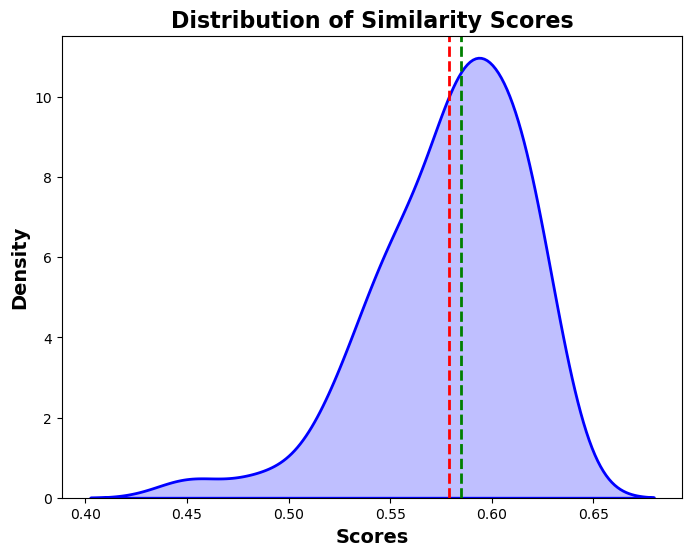

In [ ]:
# Examine distribution of similarity scores
plt.figure(figsize=(8, 6))
sns.kdeplot(data['Similarity Score'], fill=True, color='blue', linewidth=2)
# Labels and title
plt.xlabel('Scores',fontsize=14, fontweight='bold')
plt.ylabel('Density',fontsize=14, fontweight='bold')
plt.title('Distribution of Similarity Scores',fontsize=16, fontweight='bold')
# Include lines to visualize mean and median values
plt.axvline(np.mean(data['Similarity Score']), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(np.median(data['Similarity Score']), color='green', linestyle='dashed', linewidth=2, label='Median')
# Save the plot
plt.savefig('images/similarity_score_distribution.png')
# Show the plot
plt.show()
# Close the plot 
plt.close()

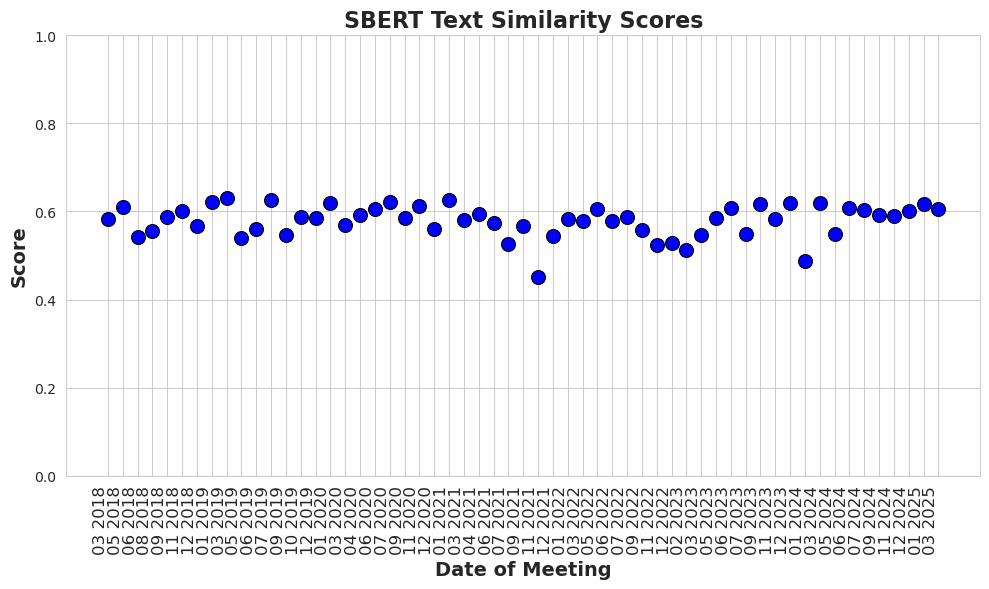

In [ ]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.set_style("whitegrid")
scatter = sns.scatterplot(data=data, x='Text', y='Similarity Score', s=100, color='blue', edgecolor='black')
plt.title('SBERT Text Similarity Scores', fontsize=16, fontweight='bold')
plt.xlabel('Date of Meeting', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.ylim(0, 1)  
plt.xticks(rotation=90, ha='right', fontsize=12)  
# Display the plot
plt.tight_layout()  
plt.show()
plt.savefig('images/similarity_score_scatter.png')
# Close the plot 
plt.close()

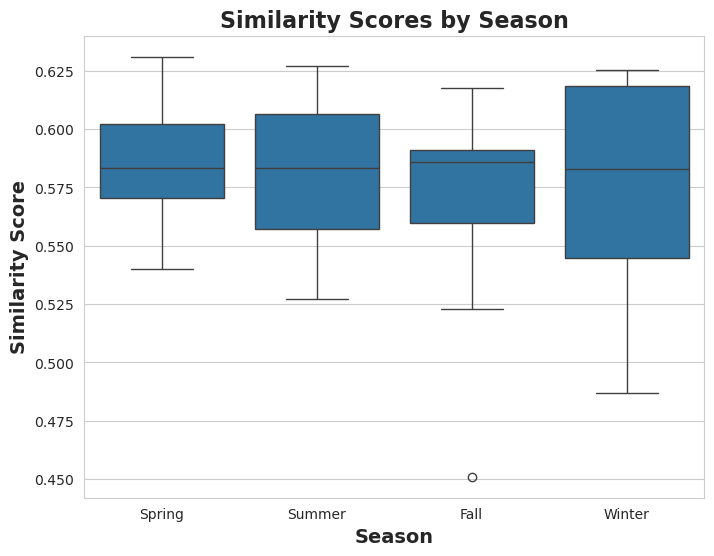

In [ ]:
# Similarity Score by Year
df=preprocess_dates(data) #process data into month and year variables for visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='Season', y='Similarity Score', data=df)
# Bold labels and title
plt.xlabel('Season',fontsize=14, fontweight='bold')
plt.ylabel('Similarity Score',fontsize=14, fontweight='bold')
plt.title('Similarity Scores by Season',fontsize=16, fontweight='bold')
# Save the plot
plt.savefig('images/similarity_score_boxplot.png')
# Show the plot 
plt.show()
# Close the plot 
plt.close()

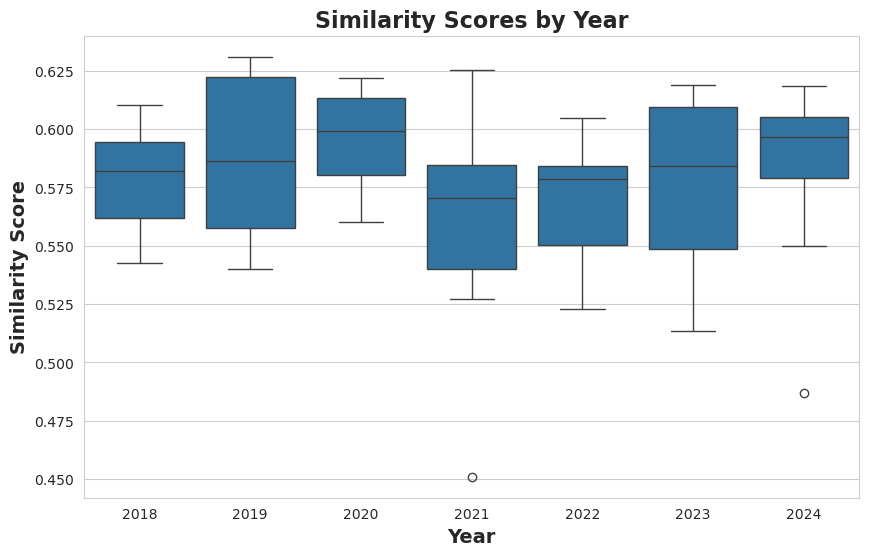

In [ ]:
# Similarity Score by Year
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Similarity Score', data=df)
# Bold labels and title
plt.xlabel('Year',fontsize=14, fontweight='bold')
plt.ylabel('Similarity Score',fontsize=14, fontweight='bold')
plt.title('Similarity Scores by Year',fontsize=16, fontweight='bold')
# Save the plot
plt.savefig('images/similarity_score_by_year.png')
# Show the plot
plt.show()
# Close the plot 
plt.close()